In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error



## Pre procesamiento


##### 1. Variables Objetivo y Características 
- **Variables objetivo (target)**: predecir el rendimiento de estudiante, se tomara variable objetivo calificacion ponderada por grado/asignatura/periodo/año
- **Características (features)**: Las demás columnas se utilizarán como características para predecir la variable objetivo.

##### 2. Tipos de Variables: 
- **Variables categóricas**: Sede, Documento de identidad, Grado, Grupo, Periodo, Año, Asignatura, Grupo Asignatura.
- **Variables numéricas**: Intensidad Horaria, Cognitiva, Procedimental, Actitudinal, Axiologica, Calificacion_Ponderada.

### Definicion de modelo y preprocesamiento
 - Ya que se tienen las notas por estudiante para cada periodo se trabaja el proyecto como una serie temporal.
 - Se cambiara la columna periodo a numerica
 - Se crea nueva columna periodo-año y se definira como indice

In [19]:
df = pd.read_csv('calificaciones_to_model_final.csv')

In [20]:
df['Periodo'].value_counts()

Periodo
I      7405
II     7383
III    3633
IV     3624
Name: count, dtype: int64


####  Cambiar columna 'Periodo' usando LabelEncoder

In [21]:
label_encoder = LabelEncoder()
df['Periodo_Num'] = label_encoder.fit_transform(df['Periodo'])
df['Periodo_Num'] += 1

df[['Periodo', 'Periodo_Num']].value_counts()

Periodo  Periodo_Num
I        1              7405
II       2              7383
III      3              3633
IV       4              3624
Name: count, dtype: int64

#### Concatenar 'Año' y 'Periodo_Num' y convertir en indice de dataframe

In [22]:

# Convertir las columnas Año y Periodo a tipo string
df['Año'] = df['Año'].astype(str)
df['Periodo_Num'] = df['Periodo_Num'].astype(str)

# Concatenar Año y Periodo en una nueva columna
df['Fecha'] = df['Año'] + '-' + df['Periodo_Num']

# Convertir la columna combinada a tipo datetime 
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')  
# Establecer la nueva columna como índice 
df.set_index('Fecha', inplace=True)

# Ordenar por el índice 
df.sort_index(inplace=True)


In [23]:
df.head()

,Sede,Documento de identidad,Grado,Grupo,Periodo,Año,Intensidad Horaria,Asignatura,Cognitiva,Procedimental,Actitudinal,Axiologica,Calificacion_Ponderada,Grupo Asignatura,Periodo_Num
Fecha,,,,,,,,,,,,,,,
2023-01-01,Fusagasugá,5db730fb0924b2de7d5e8c06eff3d6648f3b311683a3e3...,6,A,I,2023,3.0,Ciencias Naturales,77,77,97,96.0,82.9,Ciencias y Matemáticas,1
2023-01-01,Girardot,9fa5185aac452b07a4dc99c2e9d5c4aca4ba12e880a1d7...,4,A,I,2023,3.0,Educación Física,88,89,90,90.0,88.9,Artes y Educación Física,1
2023-01-01,Girardot,9fa5185aac452b07a4dc99c2e9d5c4aca4ba12e880a1d7...,4,A,I,2023,4.0,Aprendizaje Basado en Proyectos,92,91,91,90.0,91.3,Proyectos y Aprendizaje Integral,1
2023-01-01,Girardot,9fa5185aac452b07a4dc99c2e9d5c4aca4ba12e880a1d7...,4,A,I,2023,2.0,Creatividad e Innovación,93,93,95,95.0,93.6,Tecnología e Innovación,1
2023-01-01,Girardot,9fa5185aac452b07a4dc99c2e9d5c4aca4ba12e880a1d7...,4,A,I,2023,4.0,Inglés,81,82,90,90.0,84.0,Lengua y Humanidades,1


#### Exploración de Datos Temporales:

In [33]:
def grafico_lineas_ts(df_ts,columna):
    # Configurar el estilo de Seaborn
    sns.set(style='whitegrid')  

    plt.figure(figsize=(14, 8)) 
    sns.lineplot(x=df_ts.index, y='Calificacion_Ponderada', hue=columna, data=df_ts, palette='tab10', marker='o')

    # Mejorar los títulos y etiquetas
    plt.title(f"Comparación del Rendimiento por {columna}", fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Calificación Ponderada', fontsize=14)

    # Ajustar las etiquetas del eje x para que sean legibles
    plt.xticks(rotation=45)

    # Mejorar la leyenda
    plt.legend(title=columna, title_fontsize='10', fontsize='8')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()


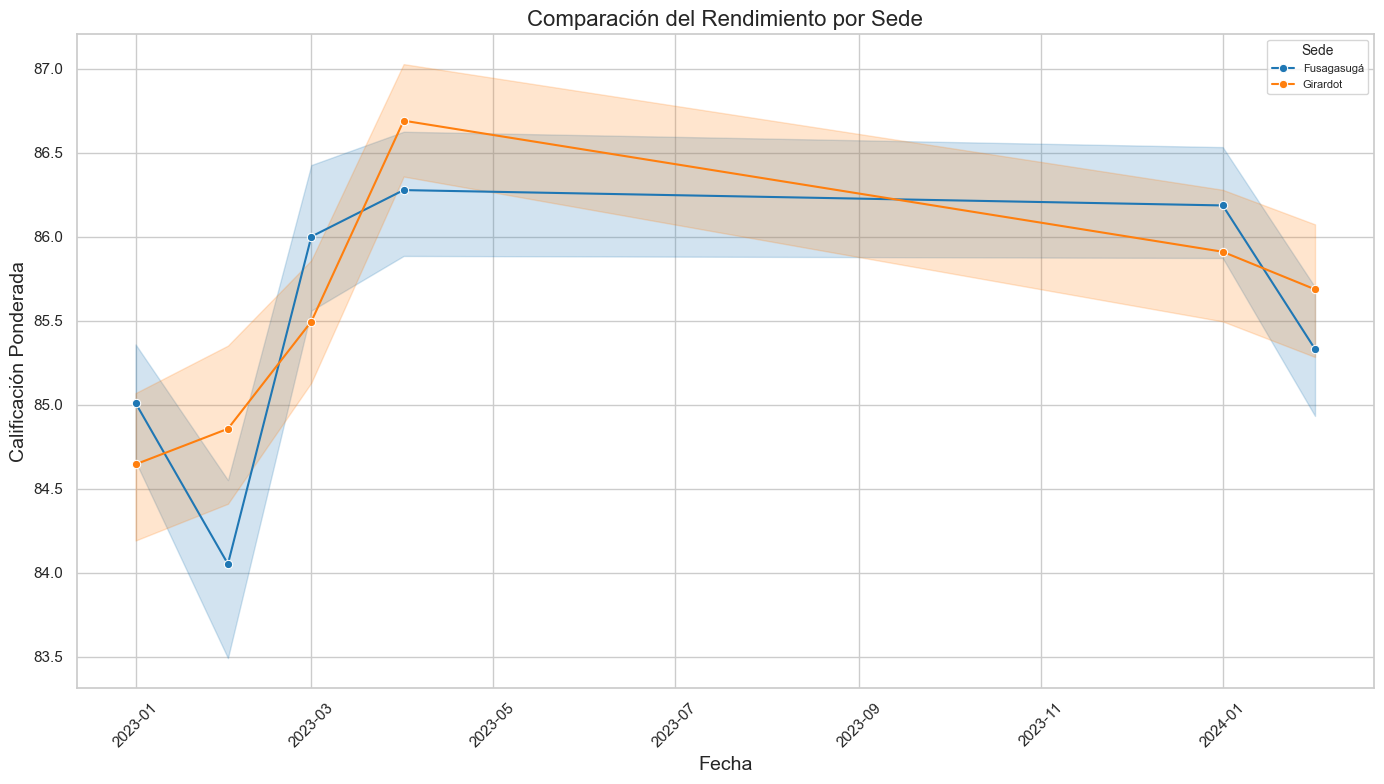

In [40]:
grafico_lineas_ts(df,'Sede')

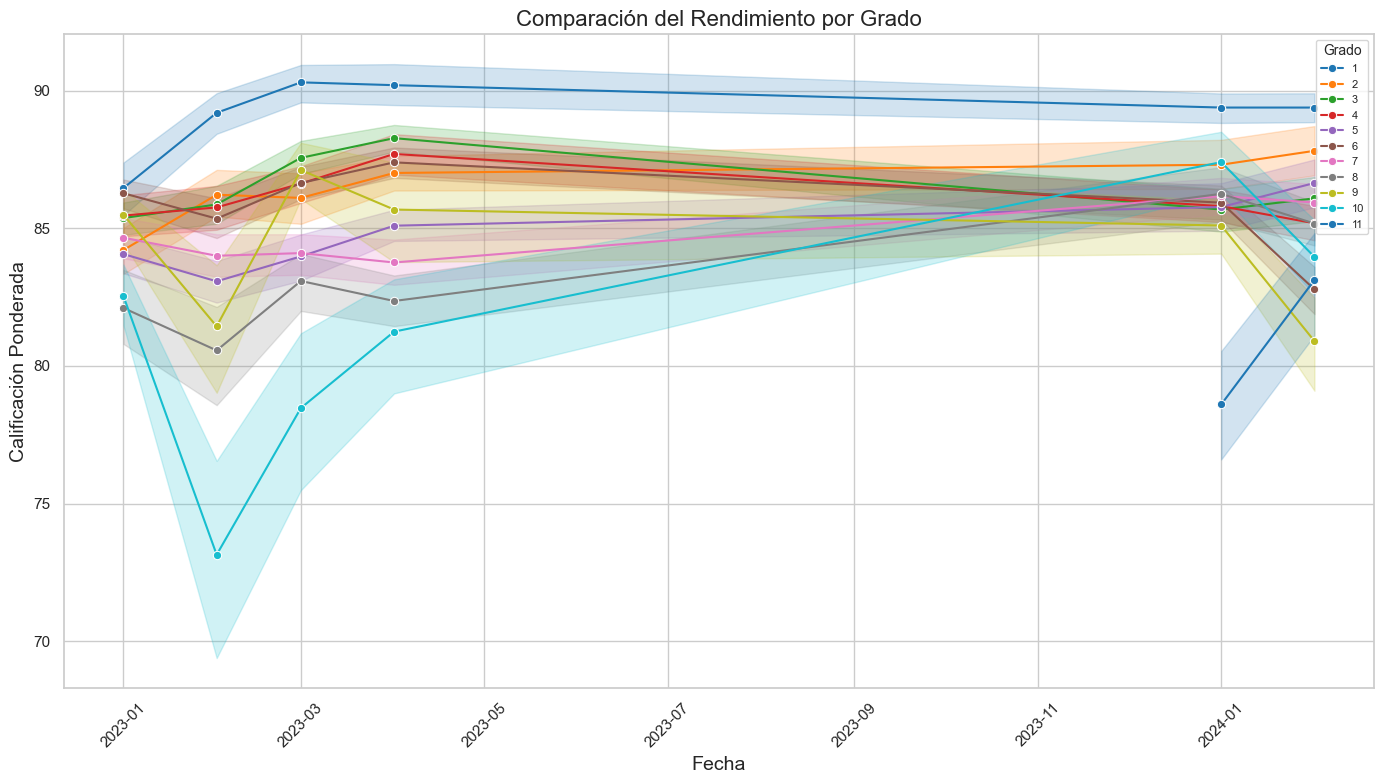

In [34]:
grafico_lineas_ts(df,'Grado')

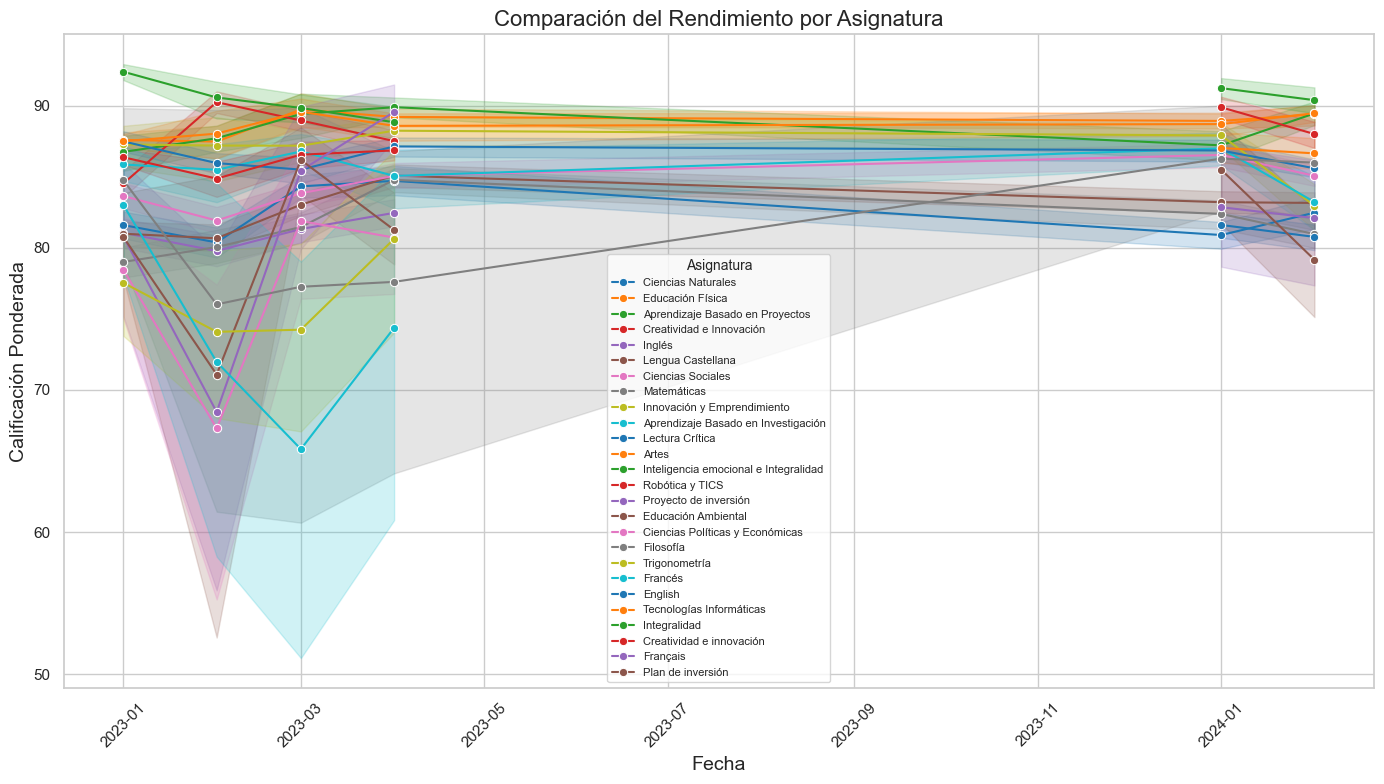

In [35]:
grafico_lineas_ts(df,'Asignatura')

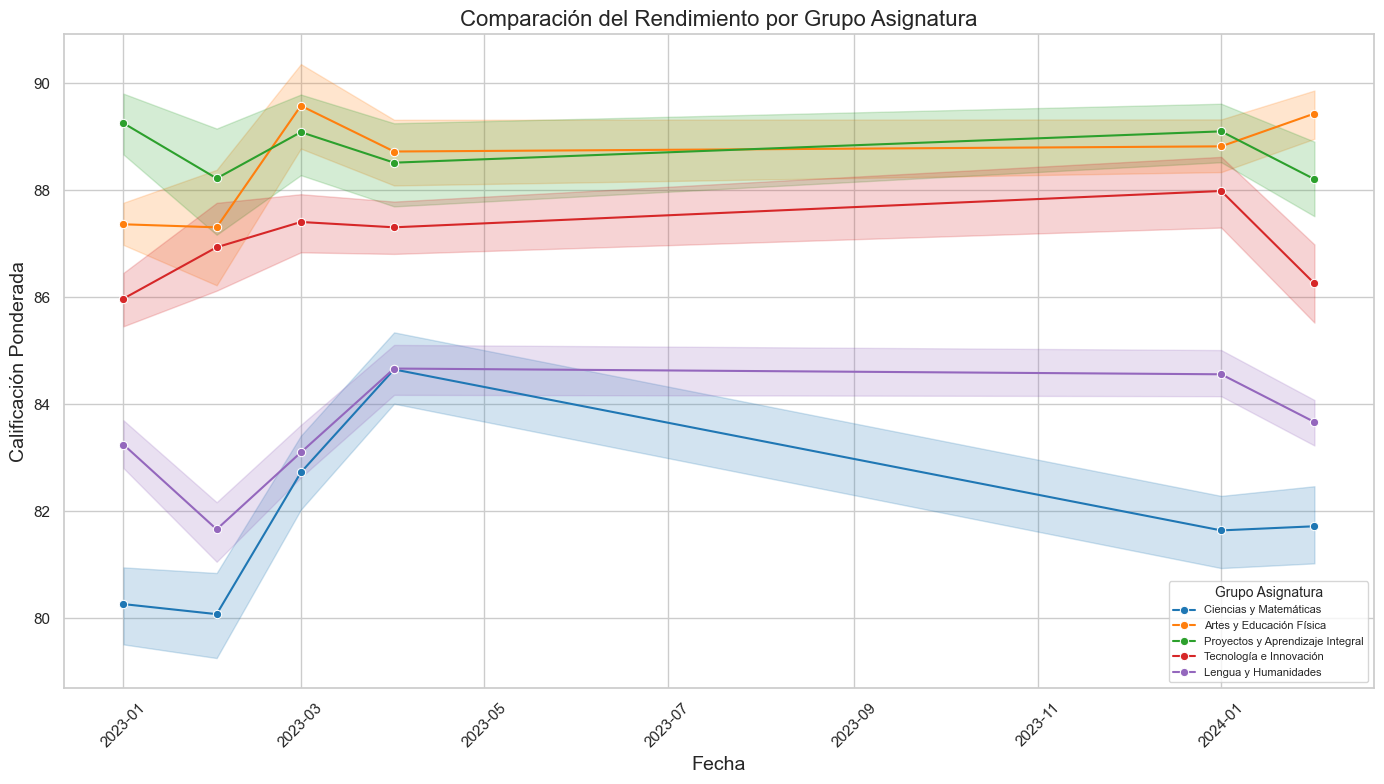

In [37]:
grafico_lineas_ts(df,'Grupo Asignatura')

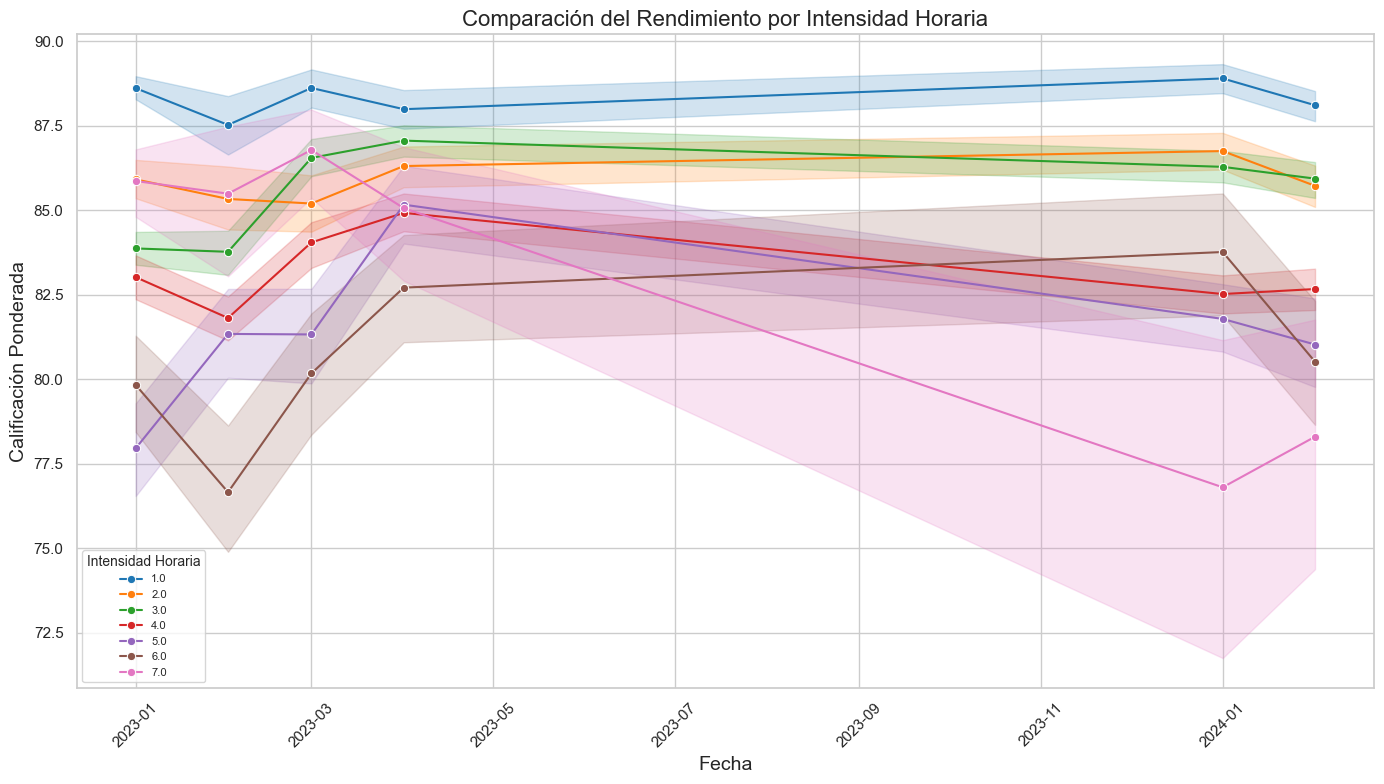

In [38]:
grafico_lineas_ts(df,'Intensidad Horaria')

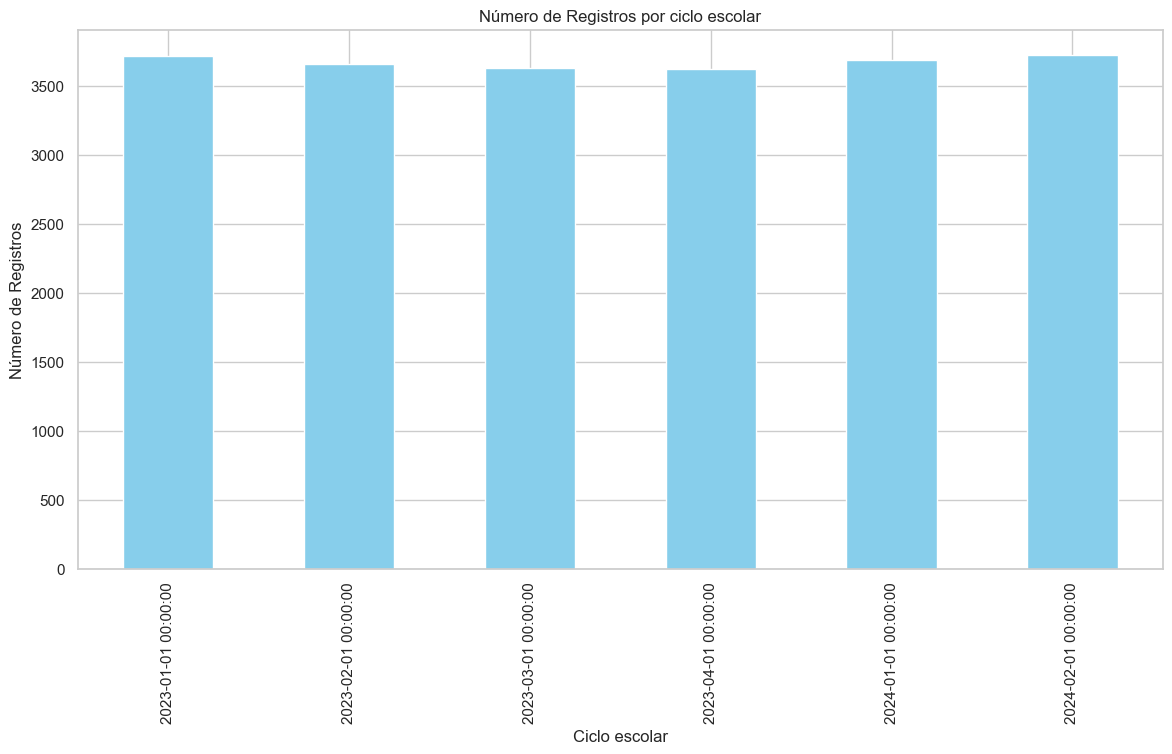

In [53]:
import matplotlib.pyplot as plt

# Contar el número de registros por ciclo escolar
record_count_per_period = df.groupby(df.index).size()

# Crear un gráfico de barras
plt.figure(figsize=(14, 7))
record_count_per_period.plot(kind='bar', color='skyblue')
plt.title('Número de Registros por ciclo escolar')
plt.xlabel('Ciclo escolar')
plt.ylabel('Número de Registros')
plt.xticks(rotation=90)  
plt.show()


In [54]:
# Agrupar por índice y contar los registros
grouped_count = df.groupby(df.index).size()
print(grouped_count)

Fecha
2023-01-01    3715
2023-02-01    3659
2023-03-01    3633
2023-04-01    3624
2024-01-01    3690
2024-02-01    3724
dtype: int64
